In [1]:
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import sklearn
import sklearn.linear_model
from sklearn.metrics import mean_squared_error, r2_score
import statsmodels.api as sm
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from __future__ import division
from __future__ import print_function
from operator import itemgetter
from itertools import combinations
import time
import os

import tensorflow as tf
import numpy as np
import networkx as nx
import scipy.sparse as sp
from sklearn import metrics

from decagon.deep.optimizer import DecagonOptimizer
from decagon.deep.model import DecagonModel
from decagon.deep.minibatch import EdgeMinibatchIterator
from decagon.utility import rank_metrics, preprocessing

/Users/ravanv/anaconda3/lib/python3.6/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools
/Users/ravanv/anaconda3/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)


In [2]:
# Train on CPU (hide GPU) due to memory constraints
os.environ['CUDA_VISIBLE_DEVICES'] = ""

# Train on GPU
# os.environ["CUDA_DEVICE_ORDER"] = 'PCI_BUS_ID'
# os.environ["CUDA_VISIBLE_DEVICES"] = '0'
# config = tf.ConfigProto()
# config.gpu_options.allow_growth = True

np.random.seed(0)

###########################################################
#
# Functions
#
###########################################################


def get_accuracy_scores(edges_pos, edges_neg, edge_type):
    feed_dict.update({placeholders['dropout']: 0})
    feed_dict.update({placeholders['batch_edge_type_idx']: minibatch.edge_type2idx[edge_type]})
    feed_dict.update({placeholders['batch_row_edge_type']: edge_type[0]})
    feed_dict.update({placeholders['batch_col_edge_type']: edge_type[1]})
    rec = sess.run(opt.predictions, feed_dict=feed_dict)

    def sigmoid(x):
        return 1. / (1 + np.exp(-x))

    # Predict on test set of edges
    preds = []
    actual = []
    predicted = []
    edge_ind = 0
    for u, v in edges_pos[edge_type[:2]][edge_type[2]]:
        score = sigmoid(rec[u, v])
        preds.append(score)
        assert adj_mats_orig[edge_type[:2]][edge_type[2]][u,v] == 1, 'Problem 1'

        actual.append(edge_ind)
        predicted.append((score, edge_ind))
        edge_ind += 1

    preds_neg = []
    for u, v in edges_neg[edge_type[:2]][edge_type[2]]:
        score = sigmoid(rec[u, v])
        preds_neg.append(score)
        assert adj_mats_orig[edge_type[:2]][edge_type[2]][u,v] == 0, 'Problem 0'

        predicted.append((score, edge_ind))
        edge_ind += 1

    preds_all = np.hstack([preds, preds_neg])
    preds_all = np.nan_to_num(preds_all)
    labels_all = np.hstack([np.ones(len(preds)), np.zeros(len(preds_neg))])
    predicted = list(zip(*sorted(predicted, reverse=True, key=itemgetter(0))))[1]

    roc_sc = metrics.roc_auc_score(labels_all, preds_all)
    aupr_sc = metrics.average_precision_score(labels_all, preds_all)
    apk_sc = rank_metrics.apk(actual, predicted, k=50)

    return roc_sc, aupr_sc, apk_sc


def construct_placeholders(edge_types):
    placeholders = {
        'batch': tf.placeholder(tf.int32, name='batch'),
        'batch_edge_type_idx': tf.placeholder(tf.int32, shape=(), name='batch_edge_type_idx'),
        'batch_row_edge_type': tf.placeholder(tf.int32, shape=(), name='batch_row_edge_type'),
        'batch_col_edge_type': tf.placeholder(tf.int32, shape=(), name='batch_col_edge_type'),
        'degrees': tf.placeholder(tf.int32),
        'dropout': tf.placeholder_with_default(0., shape=()),
    }
    placeholders.update({
        'adj_mats_%d,%d,%d' % (i, j, k): tf.sparse_placeholder(tf.float32)
        for i, j in edge_types for k in range(edge_types[i,j])})
    placeholders.update({
        'feat_%d' % i: tf.sparse_placeholder(tf.float32)
        for i, _ in edge_types})
    return placeholders

In [3]:
###########################################################
#
# Load and preprocess data (This is a dummy toy example!)
#
###########################################################

####
# The following code uses artificially generated and very small networks.
# Expect less than excellent performance as these random networks do not have any interesting structure.
# The purpose of main.py is to show how to use the code!
#
# All preprocessed datasets used in the drug combination study are at: http://snap.stanford.edu/decagon:
# (1) Download datasets from http://snap.stanford.edu/decagon to your local machine.
# (2) Replace dummy toy datasets used here with the actual datasets you just downloaded.
# (3) Train & test the model.
####


In [4]:
#bio-decagon-ppi:Protein-protein interaction network
#bio-decagon-targets: Drug-target protein associations
#bio-decagon-targets-all: Drug-target protein associations culled from several curated databases
#bio-decagon-combo:Polypharmacy side effects in the form of (drug A, side effect type, drug B) triples
#bio-decagon-effectcategories: Side effect categories
#bio-decagon-mono:Side effects of individual drugs in the form of (drug A, side effect type) tuples

<h1>Information about the datasets from the paper:</h1>
<h4>The protein-prtoein network:</h4>
number of proteins = 19,085, number of physical interactions = 719,402
<h4>The drug-prtoein network:</h4>
number of proteins = 8,934, number of drugs = 519,022, number of interactions = 8,083,600
<h4>The drug-drug network(individuale):</h4>
number of  drugs = 1,556, number of side effects = 5,868, number of drug-side effect association = 286,399
<h4>The drug-drugn network(combination):</h4>
number of  drug combinations = 63,473, number of side effect types = 1,318, number of drug combination-side effect association = 4,651,131
<h2>Final Network:</h2>
<h3>Number of protiens = 19,085 (paper) ....... Number of protiens = 19,081(ppi data) </h3>
<h3>Number of drugs = 645 (paper).......... Number of drugs = 645 (polypharmacy side effect data (combo))</h3>
<h3>Number of protien-protien edges= 715,612(paper) ....... Number of protien-protien edges= 715,612 (ppi data)</h3>
<h3>Number of drug-drug edges= 4,651,131 (paper) ......... Number of drug-drug edges= 4,649,441 (polypharmacy side effect data (combo)) </h3>
<h3>Number of drug-protien edges= 18,596 (paper) ........ Number of drug-protien edges= 18,690 (Drug-target protein (targets))</h3>

<h2>Reading real datasets</h2>

In [5]:
protein_protein_data = pd.read_csv("/Users/ravanv/Desktop/Decagon/data/bio-decagon-ppi.csv", sep=',',header = 0)
drug_target_protein_data = pd.read_csv("/Users/ravanv/Desktop/Decagon/data/bio-decagon-targets.csv", sep=',',header = 0)
#drug_target_protein_all_data = pd.read_csv("/Users/ravanv/Desktop/Decagon/data/bio-decagon-targets-all.csv", sep=',',header = 0)
polypharmacy_side_effect_data = pd.read_csv("/Users/ravanv/Desktop/Decagon/data/bio-decagon-combo.csv", sep=',',header = 0)
#side_effect_categories_data = pd.read_csv("/Users/ravanv/Desktop/Decagon/data/bio-decagon-effectcategories.csv", sep=',',header = 0)
#side_effect_individuale_data = pd.read_csv("/Users/ravanv/Desktop/Decagon/data/bio-decagon-mono.csv", sep=',',header = 0)


In [6]:
print("size of the protein-protien network:", protein_protein_data.shape)
print("size of the Drug-target protein associations:", drug_target_protein_data.shape)
#print("size of the Drug-target protein associations culled from several curated databases :",drug_target_protein_all_data.shape)
print("size of the Polypharmacy side effects:", polypharmacy_side_effect_data.shape)
#print("size of the Side effect categories:",side_effect_categories_data.shape)
#print("size of the Side effects of individual drugs:",side_effect_individuale_data.shape)

size of the protein-protien network: (715612, 2)
size of the Drug-target protein associations: (18690, 2)
size of the Polypharmacy side effects: (4649441, 4)


In [7]:
val_test_size = 0.05 #from the original code
n_genes = 19081 #from protein-protein network 
n_drugs = 645 #from drug-drug combo network
#n_genes = 23#for now, we consider a samll file!
#n_drugs = 6 #for now, we consider a samll file!

<h2> Creating a symmetric adjacency matrix for genes from the protein-protein network </h2>  

In [8]:
df_gene1_gene2 = pd.crosstab(protein_protein_data['Gene 1'], protein_protein_data['Gene 2'])
gene_idx = df_gene1_gene2.columns.union(df_gene1_gene2.index)
df_gene1_gene2 = df_gene1_gene2.reindex(index = gene_idx, columns = gene_idx,fill_value=0)#upper triangle of the adjacency matrix
df_gene2_gene1 = pd.crosstab(protein_protein_data['Gene 2'], protein_protein_data['Gene 1'])
df_gene2_gene1 = df_gene2_gene1.reindex(index = gene_idx, columns = gene_idx, fill_value=0)#lower triangle of the adjacency matrix
gene_adj = df_gene2_gene1.add(df_gene1_gene2, fill_value=0)#creates a symmetric adjacency matrix of Gene 1 and Gene 2 by adding upper triangle and lower triangle
gene_degrees = np.array(gene_adj.sum(axis=0)).squeeze()#get the degrees of genes
print("size of the gene-gene adjacecny matrix:",gene_adj.shape, ", number of genes:",len(gene_degrees))

size of the gene-gene adjacecny matrix: (19081, 19081) , number of genes: 19081


<h3>Making an adjacency matrix for the genes from the adjacency dataframe</h3>

In [9]:
indices_genes = list(range(0,len(gene_idx)))
dict_genes = dict(zip(gene_idx, indices_genes))

In [10]:
gene_adj_mat = np.zeros((n_genes,n_genes)) # matrix of size n_genes * n_genes
for i in range(0,protein_protein_data.shape[0]):#read from the protein-protein file
    gene1 = protein_protein_data.loc[i][0]#read gene1
    gene2 = protein_protein_data.loc[i][1]#read gene2
    #print(gene1,gene2)
    gene1_index = dict_genes.get(gene1)#get the index of gene1 in dictionary
    gene2_index = dict_genes.get(gene2)#get the index of gene2 in dictionary
    #print(gene1_index,gene2_index)
    gene_adj_mat[gene1_index][gene2_index] = 1.0 
    gene_adj_mat[gene2_index][gene1_index] = 1.0

In [12]:
#A=np.matrix([[0,1,1,1],[1,0,1,0],[1,1,0,0],[1,0,0,0]])
G=nx.from_numpy_matrix(gene_adj_mat)
G.edges(data=True)

[(0, 1, {'weight': 1.0}),
 (0, 16, {'weight': 1.0}),
 (0, 21, {'weight': 1.0}),
 (2, 10, {'weight': 1.0}),
 (3, 17, {'weight': 1.0}),
 (4, 16, {'weight': 1.0}),
 (5, 18, {'weight': 1.0}),
 (6, 12, {'weight': 1.0}),
 (7, 14, {'weight': 1.0}),
 (8, 15, {'weight': 1.0}),
 (9, 18, {'weight': 1.0}),
 (9, 19, {'weight': 1.0}),
 (11, 13, {'weight': 1.0}),
 (12, 13, {'weight': 1.0}),
 (20, 22, {'weight': 1.0})]

In [13]:
def show_graph_with_labels(adjacency_matrix):
    rows, cols = np.where(adjacency_matrix == 1)
    edges = zip(rows.tolist(), cols.tolist())
    gr = nx.Graph()
    gr.add_edges_from(edges)
    nx.draw(gr, node_size=500)
    plt.show()

/Users/ravanv/anaconda3/lib/python3.6/site-packages/networkx/drawing/nx_pylab.py:126: MatplotlibDeprecationWarning: pyplot.hold is deprecated.
    Future behavior will be consistent with the long-time default:
    plot commands add elements without first clearing the
    Axes and/or Figure.
  b = plt.ishold()
/Users/ravanv/anaconda3/lib/python3.6/site-packages/networkx/drawing/nx_pylab.py:522: MatplotlibDeprecationWarning: The is_string_like function was deprecated in version 2.1.
  if not cb.is_string_like(edge_color) \
/Users/ravanv/anaconda3/lib/python3.6/site-packages/networkx/drawing/nx_pylab.py:543: MatplotlibDeprecationWarning: The is_string_like function was deprecated in version 2.1.
  if cb.is_string_like(edge_color) or len(edge_color) == 1:
/Users/ravanv/anaconda3/lib/python3.6/site-packages/networkx/drawing/nx_pylab.py:138: MatplotlibDeprecationWarning: pyplot.hold is deprecated.
    Future behavior will be consistent with the long-time default:
    plot commands add elemen

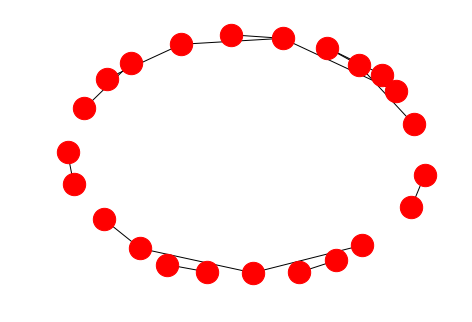

In [14]:
show_graph_with_labels(gene_adj_mat)

In [15]:
gene_adj_mat_t = gene_adj_mat.transpose()

<h2> Creating a list of symmetric adjacency matrices for each side effect from the drug-drug network (combo)</h2>

In [19]:
list_side_effects = []
prev_side_effect = []
for i in range(0,polypharmacy_side_effect_data.shape[0]):#get the list of side effects
    if polypharmacy_side_effect_data.loc[i][2] not in prev_side_effect:
        list_side_effects.append(polypharmacy_side_effect_data.loc[i][2])
        prev_side_effect.append(polypharmacy_side_effect_data.loc[i][2])

In [21]:
df_drug1_drug2 = pd.crosstab(polypharmacy_side_effect_data['STITCH 1'], polypharmacy_side_effect_data['STITCH 2'])
drug_idx = df_drug1_drug2.columns.union(df_drug1_drug2.index)

In [22]:
indices_drugs = list(range(0,len(drug_idx)))
dict_drugs = dict(zip(drug_idx, indices_drugs))

In [24]:
drug_drug_adj_list = []
for i in range(len(list_side_effects)):
    drug_drug_mat = np.zeros((n_drugs,n_drugs))
    for row_index in range(polypharmacy_side_effect_data.shape[0]):
        if polypharmacy_side_effect_data.loc[row_index][2] == list_side_effects[i]:
            drug_1 = polypharmacy_side_effect_data.loc[row_index][0]
            drug_2 = polypharmacy_side_effect_data.loc[row_index][1] 
            drug_1_index = dict_drugs.get(drug_1)
            drug_2_index = dict_drugs.get(drug_2)
            drug_drug_mat[drug_1_index,drug_2_index] =   drug_drug_mat[drug_2_index,drug_1_index] = 1.
    drug_drug_adj_list.append(sp.csr_matrix(drug_drug_mat))
drug_degrees_list = [np.array(drug_adj.sum(axis=0)).squeeze() for drug_adj in drug_drug_adj_list]

<h2> Creating an adjacency matrix for the drug-protein and protein-drug network.</h2>

In [25]:
drug_gene_adj = np.zeros((n_drugs,n_genes))
gene_drug_adj = np.zeros((n_genes, n_drugs))

In [26]:
for i in range(0,drug_gene_adj.shape[0]):
    drug = drug_target_protein_data.loc[i][0]
    gene = drug_target_protein_data.loc[i][1]
    gene_index = dict_genes.get(gene)
    drug_index = dict_drugs.get(drug)
    drug_gene_adj[drug_index][gene_index] = 1.0
    gene_drug_adj[gene_index][drug_index] = 1.0

In [27]:
adj_mats_orig = {
    (0, 0): [sp.csr_matrix(gene_adj_mat), sp.csr_matrix(gene_adj_mat_t)],
    (0, 1): [sp.csr_matrix(gene_drug_adj)],
    (1, 0): [sp.csr_matrix(drug_gene_adj)],
    (1, 1): drug_drug_adj_list + [x.transpose(copy=True) for x in drug_drug_adj_list],
}

In [28]:
degrees = {
    0: [gene_degrees, gene_degrees],
    1: drug_degrees_list + drug_degrees_list,
}
# featureless (genes)
gene_feat = sp.identity(n_genes)
gene_nonzero_feat, gene_num_feat = gene_feat.shape
gene_feat = preprocessing.sparse_to_tuple(gene_feat.tocoo())
# features (drugs)
drug_feat = sp.identity(n_drugs)
drug_nonzero_feat, drug_num_feat = drug_feat.shape
drug_feat = preprocessing.sparse_to_tuple(drug_feat.tocoo())
# data representation
num_feat = {
    0: gene_num_feat,
    1: drug_num_feat,
}
nonzero_feat = {
    0: gene_nonzero_feat,
    1: drug_nonzero_feat,
}
feat = {
    0: gene_feat,
    1: drug_feat,
}
edge_type2dim = {k: [adj.shape for adj in adjs] for k, adjs in adj_mats_orig.items()}
edge_type2decoder = {
    (0, 0): 'bilinear',
    (0, 1): 'bilinear',
    (1, 0): 'bilinear',
    (1, 1): 'dedicom',
}

In [29]:
edge_types = {k: len(v) for k, v in adj_mats_orig.items()}
num_edge_types = sum(edge_types.values())
print("Edge types:", "%d" % num_edge_types)

###########################################################
#
# Settings and placeholders
#
###########################################################

flags = tf.app.flags
FLAGS = flags.FLAGS
flags.DEFINE_integer('neg_sample_size', 1, 'Negative sample size.')
flags.DEFINE_float('learning_rate', 0.001, 'Initial learning rate.')
flags.DEFINE_integer('epochs', 50, 'Number of epochs to train.')
flags.DEFINE_integer('hidden1', 64, 'Number of units in hidden layer 1.')
flags.DEFINE_integer('hidden2', 32, 'Number of units in hidden layer 2.')
flags.DEFINE_float('weight_decay', 0, 'Weight for L2 loss on embedding matrix.')
flags.DEFINE_float('dropout', 0.1, 'Dropout rate (1 - keep probability).')
flags.DEFINE_float('max_margin', 0.1, 'Max margin parameter in hinge loss')
flags.DEFINE_integer('batch_size', 512, 'minibatch size.')
flags.DEFINE_boolean('bias', True, 'Bias term.')
# Important -- Do not evaluate/print validation performance every iteration as it can take
# substantial amount of time
PRINT_PROGRESS_EVERY = 150

print("Defining placeholders")
placeholders = construct_placeholders(edge_types)

Edge types: 34
Defining placeholders


In [30]:
print("Create minibatch iterator")
minibatch = EdgeMinibatchIterator(
    adj_mats=adj_mats_orig,
    feat=feat,
    edge_types=edge_types,
    batch_size=FLAGS.batch_size,
    val_test_size=val_test_size
)

Create minibatch iterator
Minibatch edge type: (0, 0, 0)
Constructing val edges= 0000/0030
Train edges= 0000
Val edges= 0030
Test edges= 0000
Minibatch edge type: (0, 0, 1)
Constructing val edges= 0000/0030
Train edges= 0000
Val edges= 0030
Test edges= 0000
Minibatch edge type: (0, 1, 0)
Constructing val edges= 0000/0006
Train edges= 0000
Val edges= 0006
Test edges= 0000
Minibatch edge type: (1, 0, 0)
Constructing val edges= 0000/0006
Train edges= 0000
Val edges= 0006
Test edges= 0000
Minibatch edge type: (1, 1, 0)
Constructing val edges= 0000/0002
Train edges= 0000
Val edges= 0002
Test edges= 0000
Minibatch edge type: (1, 1, 1)
Constructing val edges= 0000/0002
Train edges= 0000
Val edges= 0002
Test edges= 0000
Minibatch edge type: (1, 1, 2)
Constructing val edges= 0000/0002
Train edges= 0000
Val edges= 0002
Test edges= 0000
Minibatch edge type: (1, 1, 3)
Constructing val edges= 0000/0002
Train edges= 0000
Val edges= 0002
Test edges= 0000
Minibatch edge type: (1, 1, 4)
Constructing va

/Users/ravanv/Desktop/Decagon/decagon-master/decagon/deep/minibatch.py:67: RuntimeWarning: divide by zero encountered in power
  rowdegree_mat_inv = sp.diags(np.nan_to_num(np.power(rowsum, -0.5)).flatten())
/Users/ravanv/Desktop/Decagon/decagon-master/decagon/deep/minibatch.py:68: RuntimeWarning: divide by zero encountered in power
  coldegree_mat_inv = sp.diags(np.nan_to_num(np.power(colsum, -0.5)).flatten())


In [31]:
print("Create model")
model = DecagonModel(
    placeholders=placeholders,
    num_feat=num_feat,
    nonzero_feat=nonzero_feat,
    edge_types=edge_types,
    decoders=edge_type2decoder,
)

Create model


In [32]:
print("Create optimizer")
with tf.name_scope('optimizer'):
    opt = DecagonOptimizer(
        embeddings=model.embeddings,
        latent_inters=model.latent_inters,
        latent_varies=model.latent_varies,
        degrees=degrees,
        edge_types=edge_types,
        edge_type2dim=edge_type2dim,
        placeholders=placeholders,
        batch_size=FLAGS.batch_size,
        margin=FLAGS.max_margin
    )

Create optimizer


/Users/ravanv/anaconda3/lib/python3.6/site-packages/tensorflow/python/ops/gradients_impl.py:96: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


In [33]:
print("Initialize session")
sess = tf.Session()
sess.run(tf.global_variables_initializer())
feed_dict = {}

Initialize session


In [34]:
###########################################################
#
# Train model
#
###########################################################

print("Train model")
for epoch in range(FLAGS.epochs):

    minibatch.shuffle()
    itr = 0
    while not minibatch.end():
        # Construct feed dictionary
        feed_dict = minibatch.next_minibatch_feed_dict(placeholders=placeholders)
        feed_dict = minibatch.update_feed_dict(
            feed_dict=feed_dict,
            dropout=FLAGS.dropout,
            placeholders=placeholders)

        t = time.time()

        # Training step: run single weight update
        outs = sess.run([opt.opt_op, opt.cost, opt.batch_edge_type_idx], feed_dict=feed_dict)
        train_cost = outs[1]
        batch_edge_type = outs[2]

        if itr % PRINT_PROGRESS_EVERY == 0:
            val_auc, val_auprc, val_apk = get_accuracy_scores(
                minibatch.val_edges, minibatch.val_edges_false,
                minibatch.idx2edge_type[minibatch.current_edge_type_idx])

            print("Epoch:", "%04d" % (epoch + 1), "Iter:", "%04d" % (itr + 1), "Edge:", "%04d" % batch_edge_type,
                  "train_loss=", "{:.5f}".format(train_cost),
                  "val_roc=", "{:.5f}".format(val_auc), "val_auprc=", "{:.5f}".format(val_auprc),
                  "val_apk=", "{:.5f}".format(val_apk), "time=", "{:.5f}".format(time.time() - t))

        itr += 1

print("Optimization finished!")

Train model


KeyboardInterrupt: 

In [ ]:
for et in range(num_edge_types):
    roc_score, auprc_score, apk_score = get_accuracy_scores(
        minibatch.test_edges, minibatch.test_edges_false, minibatch.idx2edge_type[et])
    print("Edge type=", "[%02d, %02d, %02d]" % minibatch.idx2edge_type[et])
    print("Edge type:", "%04d" % et, "Test AUROC score", "{:.5f}".format(roc_score))
    print("Edge type:", "%04d" % et, "Test AUPRC score", "{:.5f}".format(auprc_score))
    print("Edge type:", "%04d" % et, "Test AP@k score", "{:.5f}".format(apk_score))
    print()
